## Parameter identification for various models

To investigate the performance of parameter identification for different electrochemical models we will start with synthetic data from the highest order model in PyBOP (Many-particle DFN) and try to identify the correct parameter values on the reduced order models.

### Setting up the Environment

Before we begin, we need to ensure that we have all the necessary tools. We will install PyBOP from its development branch and upgrade some dependencies:

In [1]:
%pip install --upgrade pip ipywidgets pybamm -q
%pip install pybop -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Next, we import the added packages plus any additional dependencies,

In [2]:
import numpy as np
import plotly.graph_objects as go
import pybamm

import pybop

## Optimising the Parameters

First, we define the model to be used for the parameter optimisation,

In [3]:
parameter_set = pybop.ParameterSet.pybamm("Chen2020")
parameter_set = pybamm.get_size_distribution_parameters(parameter_set)
synth_model = pybop.lithium_ion.DFN(
    parameter_set=parameter_set, options={"particle size": "distribution"}
)

### Simulating Forward Model

We can then simulate the model using the `predict` method, with a default constant current to generate voltage data.

In [4]:
n_points = 650
t_eval = np.linspace(0, 1600 + 1000, n_points)
current = np.concatenate(
    [np.ones(400) * parameter_set["Nominal cell capacity [A.h]"], np.zeros(250)]
)
init_soc = 0.5

In [5]:
dataset = pybop.Dataset(
    {
        "Time [s]": t_eval,
        "Current function [A]": current,
    }
)

In [6]:
synth_model.build(dataset, init_soc=init_soc)
synth_model.signal = ["Voltage [V]"]
values = synth_model.simulate(t_eval=t_eval, inputs={})

### Adding Noise to Voltage Data

To make the parameter estimation more realistic, we add Gaussian noise to the data.

In [7]:
sigma = 0.001
corrupt_values = values["Voltage [V]"].data + np.random.normal(
    0, sigma, len(values["Voltage [V]"].data)
)
go.Figure(
    data=go.Scatter(x=t_eval, y=corrupt_values, mode="lines"),
    layout=go.Layout(title="Corrupted Voltage", width=800, height=600),
)

## Identifying the Parameters

We will now set up the parameter estimation process by defining the datasets for optimisation and selecting the model parameters we wish to estimate.

### Creating a Dataset

The dataset for optimisation is composed of time, current, and the noisy voltage data:

In [8]:
dataset = pybop.Dataset(
    {
        "Time [s]": t_eval,
        "Current function [A]": current,
        "Voltage [V]": corrupt_values,
    }
)

Next, we define the model parameters for optimisation. Furthermore, PyBOP provides functionality to define a prior for the parameters. The initial parameter values used in the optimisation will be randomly drawn from the prior distribution.

In [9]:
parameters = pybop.Parameters(
    pybop.Parameter(
        "Positive electrode thickness [m]",
        prior=pybop.Gaussian(7e-05, 0.1e-05),
        bounds=[50e-06, 110e-06],
        true_value=parameter_set["Positive electrode thickness [m]"],
    ),
    pybop.Parameter(
        "Negative electrode thickness [m]",
        prior=pybop.Gaussian(7.5e-05, 0.1e-05),
        bounds=[50e-06, 110e-06],
        true_value=parameter_set["Negative electrode thickness [m]"],
    ),
)

We can now construct the models for fitting. In this example, we will complete parameter estimation for both the single particle model (SPM) and the single particle model with electrolyte (SPMe).

In [10]:
models = [
    pybop.lithium_ion.SPM(parameter_set=parameter_set),
    pybop.lithium_ion.SPMe(parameter_set=parameter_set),
]

Let's construct PyBOP's optimisation class for each model. This class provides the methods needed to fit the forward model. For this example, we use an evolution strategy (XNES) as the optimiser.

In [11]:
optims = []
xs = []
for model in models:
    print(f"Running {model.name}")
    problem = pybop.FittingProblem(model, parameters, dataset, init_soc=init_soc)
    cost = pybop.SumSquaredError(problem)
    optim = pybop.CMAES(
        cost,
        verbose=True,
        max_iterations=60,
        max_unchanged_iterations=15,
        absolute_tolerance=5e-6,
    )
    x, final_cost = optim.run()
    optims.append(optim)
    xs.append(x)

Running Single Particle Model
Halt: Maximum number of iterations (60) reached.
Running Single Particle Model with Electrolyte
Halt: No significant change for 15 iterations.


In [12]:
for optim, x in zip(optims, xs):
    print(f"| Model: {optim.cost.problem.model.name} | Results: {x} |")

| Model: Single Particle Model | Results: [5.59967461e-05 8.84873536e-05] |
| Model: Single Particle Model with Electrolyte | Results: [1.02146851e-04 7.49306662e-05] |


## Plotting and Visualisation

PyBOP provides various plotting utilities to visualise the results of the optimisation.

### Comparing System Response

We can quickly plot the system's response using the estimated parameters compared to the initial parameters:


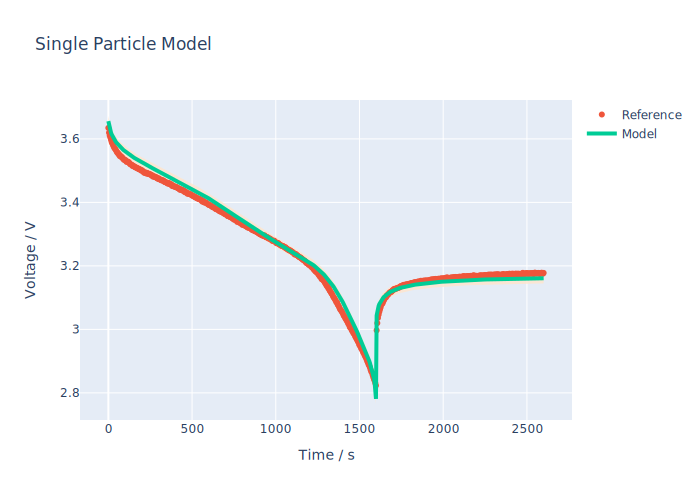

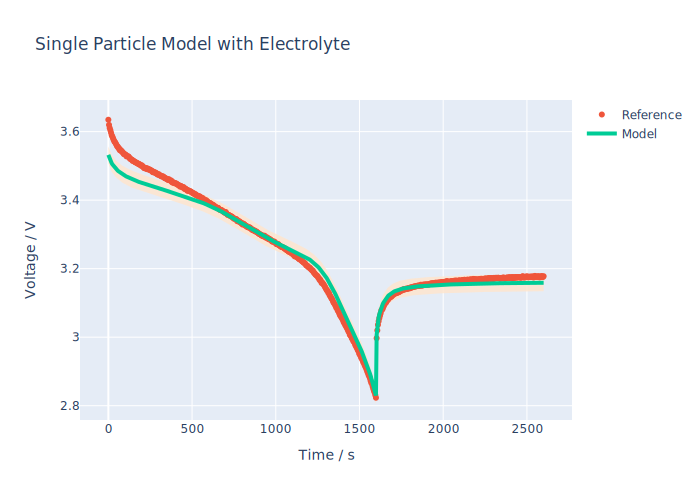

In [13]:
for optim, x in zip(optims, xs):
    pybop.quick_plot(
        optim.cost.problem, problem_inputs=x, title=optim.cost.problem.model.name
    )

### Cost Landscape

Finally, we can visualise the cost landscape and the path taken by the optimiser:


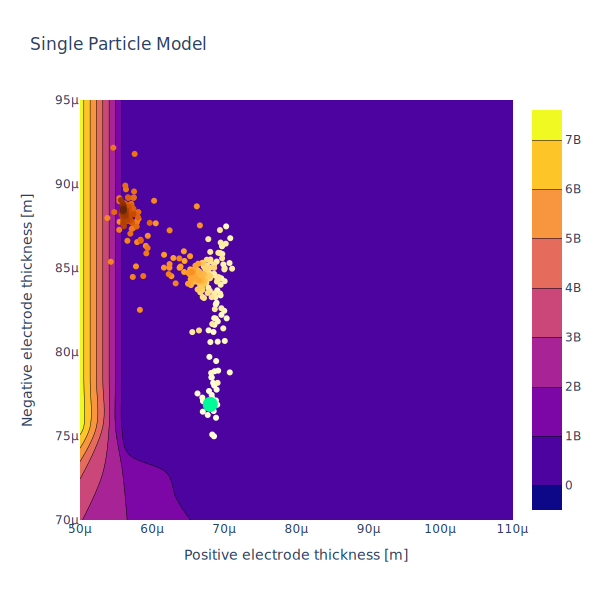

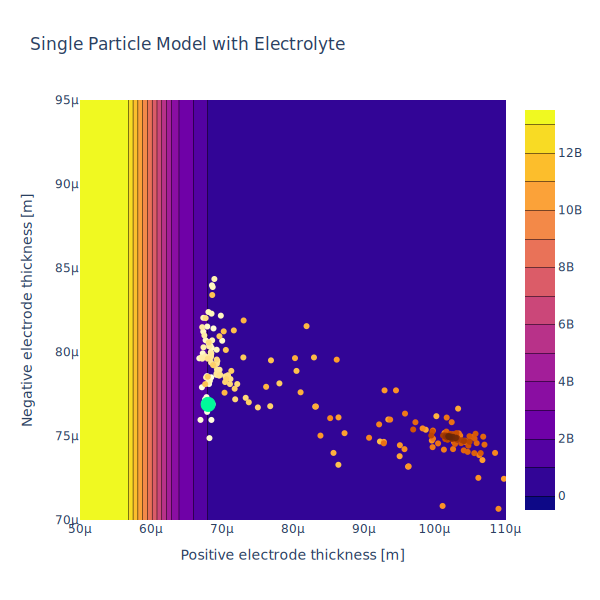

In [15]:
bounds = np.asarray([[5.0e-05, 11e-05], [7.0e-05, 9.5e-05]])
for optim in optims:
    pybop.plot2d(optim, bounds=bounds, steps=10, title=optim.cost.problem.model.name)